# VV in SiC
An example of computing Free Induction Decay (FID) and Hahn-echo (HE) with hyperfine couplings from GIPAW for axial and basal divacancies.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import ase
import pandas as pd
import warnings
import pycce as pc

np.set_printoptions(suppress=True, precision=5)
warnings.simplefilter("ignore")

seed = 8805

/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Axial kk-VV
First we compute FID and HE for axial divacancy.

# Build BathCell from the ground
One can set up a BathCell instance by providing the parameters of the unit cell, or cell argument as 3x3 tensor, where each column defines a, b, c unit cell vectors in cartesian coordinates.
In this tutorial we use the first approach.

In [4]:
# Set up unit cell with (a, b, c, alpha, beta, gamma)
sic = pc.BathCell(3.073, 3.073, 10.053, 90, 90, 120, 'deg')
# z axis in cell coordinates
sic.zdir = [0, 0, 1]
# Next, user has to define positions of atoms in the unit cell. It is done with BathCell.add_atoms function. It takes an unlimited number of arguments, each argument is a tuple. First element of the tuple is the name of the atom, second - list of xyz coordinates either in cell units (if keyword type='cell', default value) or in Angstrom (if keyword type='angstrom'). Returns BathCell.atoms dictionary, which contains list of coordinates for each type of elements.
# position of atoms
sic.add_atoms(('Si', [0.00000000, 0.00000000, 0.1880]),
              ('Si', [0.00000000, 0.00000000, 0.6880]),
              ('Si', [0.33333333, 0.66666667, 0.4380]),
              ('Si', [0.66666667, 0.33333333, 0.9380]),
              ('C', [0.00000000, 0.00000000, 0.0000]),
              ('C', [0.00000000, 0.00000000, 0.5000]),
              ('C', [0.33333333, 0.66666667, 0.2500]),
              ('C', [0.66666667, 0.33333333, 0.7500]))

defaultdict(list,
            {'Si': [array([0.   , 0.   , 0.188]),
              array([0.   , 0.   , 0.688]),
              array([0.33333, 0.66667, 0.438  ]),
              array([0.66667, 0.33333, 0.938  ])],
             'C': [array([0., 0., 0.]),
              array([0. , 0. , 0.5]),
              array([0.33333, 0.66667, 0.25   ]),
              array([0.66667, 0.33333, 0.75   ])]})

Two types of isotopes present in SiC: 
- Si 
- C 

We add this information with the BathCell.add_isotopes function. The code knows most of the concentrations, so this step is actually unnecessary. If no isotopes is provided, the natural concentration of common magnetic isotopes is assumed.

In [5]:
# isotopes
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))

# defect position in cell units
vsi_cell = [0, 0, 0.1880]
vc_cell = [0, 0, 0]

# Generate bath spin positions
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                          seed=seed)

# Read Quantum Espresso output
PyCCE provides a helper function read_qe in pycce.io module to read hyperfine couplings from quantum espresso output. read_qe takes from 1 to 3 positional arguments:
- pwfile: name of the pw input/output file;
- hyperfine: name of the gipaw output file containing hyperfine couplings;
- efg: name of the gipaw output file containing electric field tensor calculations.

During its call, read_qe will read the cell matrix in pw file and apply it to the coordinates is necessary. However, usually we still need to rotate and translate the Quantum Espresso supercell to align it with our BathArray. To do so we can provide additional keywords arguments center and rotation_matrix. center is the position of (0, 0, 0) point in coordinates of pw file, and rotation_matrix is rotation matrix which aligns z-direction of the GIPAW output. This matrix, acting on the (0, 0, 1) in Cartesian coordinates of GIPAW output should produce (a, b, c) vector, aligned with zdirection of the BathCell. Keyword argument rm_style shows whether rotation_matrix contains coordinates of new basis set as rows ('row', common in physics) or as columns ('col', common in maths).


# !! Explaining what this is trying to convey !!
This part of the tutorial is explaining how to use a specific function (read_qe) from the pycce.io module, which is part of the PyCCE package, to read and process output files generated by Quantum Espresso (a widely-used software package for quantum chemistry and solid-state physics simulations) during certain calculations. Here's a step-by-step breakdown of each portion of the excerpt:

### 1. Reading Quantum Espresso Output with read_qe
The read_qe function helps in reading the output files generated by Quantum Espresso, particularly focusing on hyperfine couplings and electric field tensor calculations which are vital in computational studies involving magnetic resonance.

### 2. Positional Arguments of read_qe
pwfile: This argument is used to specify the name (or path) of the input/output file generated by Quantum Espresso during a plane-wave calculation (indicated by "pw"). This file contains essential details about the structure and conditions of the calculation.

hyperfine: This argument indicates the name (or path) of the GIPAW output file which contains data regarding hyperfine couplings. Hyperfine couplings are crucial parameters when studying nuclear spin interactions in materials.

efg: This argument is for specifying the name (or path) of the GIPAW output file that contains the results of electric field gradient tensor calculations. These tensors are important in studies involving nuclear quadrupole interactions.

### 3. Post-Processing and Alignment with BathArray
After reading in the necessary data, additional steps might be needed to properly align the simulation cell (from Quantum Espresso) with the coordinate system used in the PyCCE package (referred to as BathArray).

Center: This keyword argument specifies the coordinates of the origin (0, 0, 0) in the coordinate system used in the pwfile. This helps in aligning the simulation cells properly.

Rotation_Matrix: This is a matrix that is used to align the z-direction of the GIPAW output with the z-direction of the BathCell in PyCCE. This matrix acts on a unit vector along the z-direction in the GIPAW Cartesian coordinate system to produce a new vector (a, b, c) that is aligned with the z-direction in the BathCell coordinate system.

rm_style: This argument indicates the orientation of the basis vectors in the rotation matrix. If it is 'row', the basis vectors are represented as rows in the matrix (common in physics), whereas if it's 'col', they are represented as columns (common in mathematics).

In [6]:
# Prepare rotation matrix to align with z axis of generated atoms
# This matrix, acting on the [0, 0, 1] in Cartesian coordinates of the GIPAW output,
# Should produce [a, b, c] vector, aligned with the z-direction of the BathCell
M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Position of (0,0,0) point in cell coordinates
center = [0.6, 0.5, 0.5]
# Read GIPAW results
exatoms = pc.read_qe('axial/pw.in',
                     hyperfine='axial/gipaw.out',
                     center=center, rotation_matrix=M,
                     rm_style='col',
                     isotopes={'C':'13C', 'Si':'29Si'})


`pc.read_qe` produces an instance of BathArray, with names of bath spins being the most common isotopes of the respective elements (if the keyword `isotopes` is set to None) or derived from the mapping provided by the `isotopes` argument.

## Set up CCE Simulator
In this example, we set up a bare Simulator and add the properties of the spin bath later.

In [34]:
# Setting up CCE calculations
pos = sic.to_cartesian(vsi_cell)
CCE_order = 2
r_bath = 40
r_dipole = 8
B = np.array([0, 0, 500])

calc = pc.Simulator(1, pos, alpha=[0, 0, 1], beta=[0, 1, 0], magnetic_field=B)
# Function Simulator.read_bath can be called explicitly to initialize the spin bath. The additional keyword argument external_bath takes an instance of BathArray with hyperfine couplings read from Quantum Espresso. The program then identifies the spins with the same name at the same positions (within the range defined by the error_range keyword argument) in the total bath and sets their hyperfine couplings.
# Finally, we call Simulator.generate_clusters to identify the bath spin clusters in the provided bath.
calc.read_bath(atoms, r_bath, external_bath=exatoms);
calc.generate_clusters(CCE_order, r_dipole=r_dipole);

## FID with DFT Hyperfine Couplings
In this segment, the `pulses` argument is provided directly to the compute function, instead of during the initialization of the Simulator object.

In [8]:
time_space = np.linspace(0, 0.01, 501)
N = 0

ldft = calc.compute(time_space, pulses=N, as_delay=False)

## FID with Hyperfine Couplings from Point Dipole Approximation

In [9]:
pdcalc = pc.Simulator(1, pos, alpha=[0, 0, 1], beta=[0, 1, 0], magnetic_field=B,
                      bath=atoms, r_bath=r_bath, order=CCE_order, r_dipole=r_dipole)
lpd = pdcalc.compute(time_space, pulses=N, as_delay=False)

Now we will plot the results and verify that the predictions are significantly different.

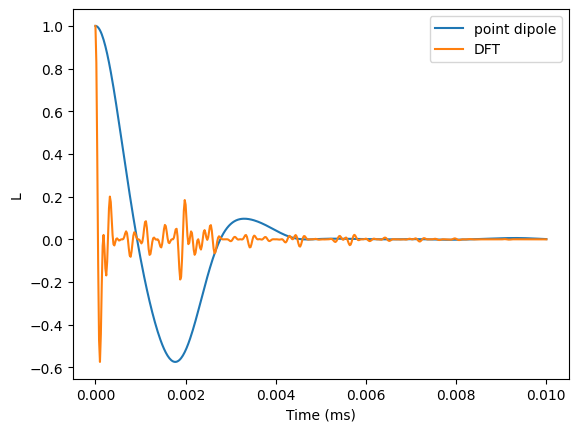

In [10]:
plt.plot(time_space, lpd.real, label='point dipole')
plt.plot(time_space, ldft.real, label='DFT')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('L');

## Hahn-echo Comparison
Now, we will compare the predictions for the Hahn-echo signal using different hyperfine couplings.

In [11]:
he_time = np.linspace(0, 2.5, 501)
B = np.array([0, 0, 500])
N = 1

he_ldft = calc.compute(he_time, magnetic_field=B, pulses=N, as_delay=False)
he_lpd = pdcalc.compute(he_time, magnetic_field=B, pulses=N, as_delay=False)

Next, we plot the results and make a comparison. It is observed that the modulations in the electron spin echo differ significantly, while the observed decay remains roughly the same.

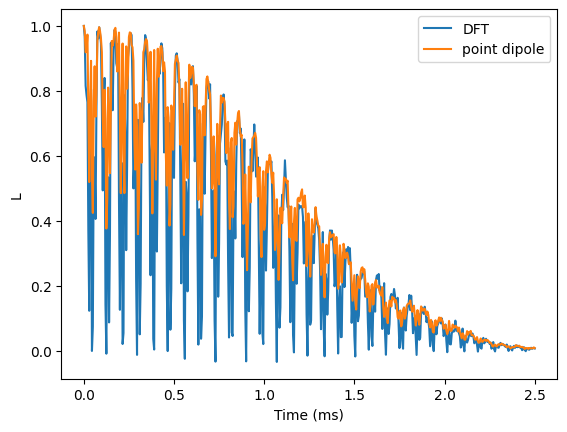

In [12]:
plt.plot(he_time, he_ldft.real, label='DFT')
plt.plot(he_time, he_lpd.real, label='point dipole')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('L');

## Basal kh-VV in SiC
In this section, we focus on the basal divacancy's Hamiltonian which incorporates both D and E terms, facilitating the mixing between +1 and -1 spin levels even at zero field. Consequently, one can either employ the generalized CCE or add supplementary perturbational Hamiltonian terms. In this instance, the generalized CCE framework is utilized.

Firstly, we need to prepare the rotation matrix for the DFT results. Although the same supercell was employed to compute the hyperfine couplings, the z-axis of the electron spin qubit aligns with the Si-C bond, necessitating the rotation of the DFT supercell accordingly.

In [13]:
# Coordinates of vacancies in cell coordinates (note that Vsi is not located in the first unit cell)
vsi_cell = -np.array([1 / 3, 2 / 3, 0.0620])
vc_cell = np.array([0, 0, 0])

sic.zdir = [0, 0, 1]

# Rotation matrix for DFT supercell
R = pc.rotmatrix([0, 0, 1], sic.to_cartesian(vsi_cell - vc_cell))

To initialize the total spin bath, simply set the z-direction of the BathCell object accordingly.

In [14]:
sic.zdir = vsi_cell - vc_cell ### ????

# Generate bath spin positions
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                          seed=seed)

First, read the DFT results using the `read_qe` function. To accurately rotate into the correct frame, it is necessary to apply both basis changes sequentially.

In [15]:
M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Position of (0,0,0) point in cell coordinates
center = np.array([0.59401, 0.50000, 0.50000])

# Read GIPAW results
exatoms = pc.read_qe('basal/pw.in',
                     hyperfine='basal/gipaw.out',
                     center=center, rotation_matrix=(M.T @ R),
                     rm_style='col',
                     isotopes={'C':'13C', 'Si':'29Si'})

To ensure the rotations were executed correctly, we can use the `pc.same_bath_indexes` function to identify the indices where the BathArray and the DFT output coincide. This function returns a tuple with indices representing elements with identical positions and names from both BathArray instances. We will generate a supercell with the BathCell class, containing only 100% isotopes, and verify that the number of found indices matches the size of the DFT supercell.

In [35]:
# isotopes
sic.add_isotopes(('29Si', 1), ('13C', 1))
allcell = sic.gen_supercell(50, remove=[('Si', vsi_cell),
                                        ('C', vc_cell)],
                            seed=seed)

indexes, ext_indexes = pc.same_bath_indexes(allcell, exatoms, 0.2, True)
print(f"There are {indexes.size} same elements."
      f" Size of the DFT supercell is {exatoms.size}")

# ---OUTPUT---
# There are 1438 same elements. Size of the DFT supercell is 1438

There are 1438 same elements. Size of the DFT supercell is 1438


### Setting up Calculations
Now, we are ready to initiate the calculations of the coherence function utilizing DFT couplings. We intend to contrast the results derived with and without incorporating bath state sampling.

In [53]:
E_calc = 18.4 *(1e3) # in Hz
E_calc2 = 0.0184 *(1e6)

if E_calc == E_calc2:
    print('yes')

yes


In [17]:
D = 1.334 * 1e6 # in kHz (D = 1.334 GHz)
E = 18.4 * 1e3 # in kHz (E = 18.4 MHz)
magnetic_field = 0

print(E/D)

calc = pc.Simulator(1, pos, bath=atoms, external_bath=exatoms, D=D, E=E,
                    magnetic_field=magnetic_field, alpha=0, beta=1,
                    r_bath=r_bath, order=CCE_order, r_dipole=r_dipole)

0.013793103448275862


The code automatically identifies and utilizes the two lowest eigenstates of the central spin Hamiltonian as qubit states. You can check the details of the simulation configuration by printing the calculator object.

In [18]:
print(calc)

Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 761 spins.

Clusters include:
761  clusters of order 1.
1870  clusters of order 2.



Furthermore, we can utilize the `CenterArray`, accessible via the `Simulator.center` attribute, to scrutinize the qubit states in the absence of the nuclear spin bath.

In [19]:
calc.center.generate_states()
print(f'0 state: {calc.alpha.real}; 1 state: {calc.beta.real}')

# ---OUTPUT---
# 0 state: [ 0. -1.  0.]; 1 state: [ 0.70711  0.      -0.70711]

0 state: [ 0. -1.  0.]; 1 state: [ 0.70711  0.      -0.70711]


### Free Induction Decay (FID)
At this point, we will utilize the generalized CCE to calculate the Free Induction Decay (FID) of the coherence function across different CCE orders.

In [54]:
N = 0 # Number of pulses
time_space = np.linspace(0, 1, 101) # Time points at which to compute

orders = [1, 2, 3]
lgen = []

r_bath = 30
r_dipole = 8

calc = pc.Simulator(1, pos, bath=atoms, external_bath=exatoms,
                    D=D, E=E, pulses=N, alpha=0, beta=1,
                    r_bath=r_bath, r_dipole=r_dipole)

for o in orders:
    calc.generate_clusters(o)
    l = calc.compute(time_space, method='gcce',
                     quantity='coherence', as_delay=False)
    
    lgen.append(np.abs(l))

lgen = pd.DataFrame(lgen, columns=time_space, index=orders).T

Notice that the results do not converge as expected. Instead, they begin to diverge. Employing bath sampling (by setting `nbstates` to a specific value) can address this issue.

To visualize the data, we plot the results:

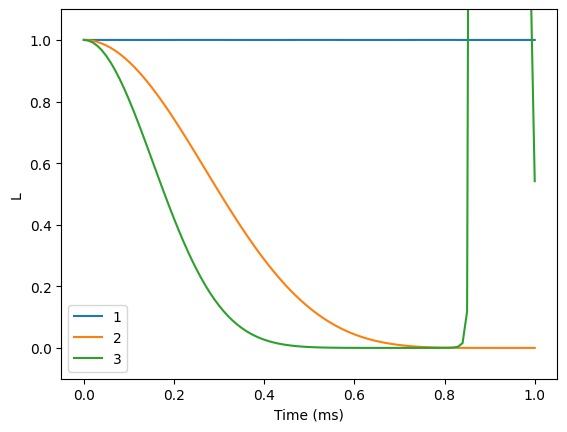

In [55]:
lgen.plot()
plt.xlabel('Time (ms)')
plt.ylabel('L')
plt.ylim(-0.1, 1.1);

Please note that implementing this method is considerably more resource-intensive, being `nbstates` times more expensive than the gCCE. Therefore, the upcoming calculation is expected to take a few minutes.

In [44]:
orders = [1, 2]
lgcce = []

r_bath = 30
r_dipole = 6

for o in orders:
    calc.generate_clusters(o)

    l = calc.compute(time_space, nbstates=30, seed=seed,
                     method='gcce',
                     quantity='coherence', as_delay=False)

    lgcce.append(np.abs(l))

lgcce = pd.DataFrame(lgcce, columns=time_space, index=orders).T

### Compare the two results
In this section, we will compare the results obtained using gCCE at different settings. It is noted that the first order results from the gCCE method seem to converge, however, due to the small number of bath states utilized (30), the calculations might not be fully converged. Using a larger number of bath states, around 100, could potentially yield more accurate results. Let's plot these comparisons:

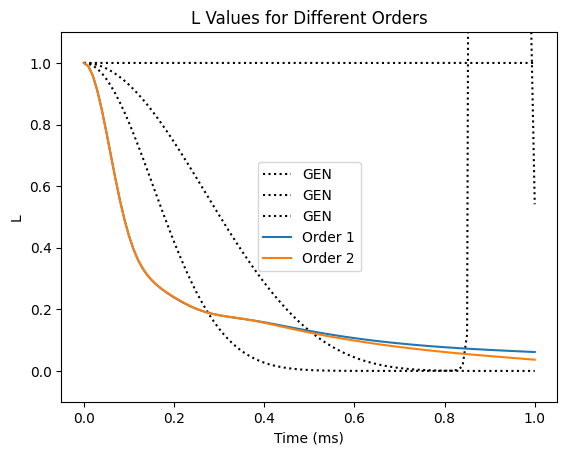

In [46]:
# plt.plot(lgen, color='black', ls=':')
# plt.plot(lgcce)

# plt.xlabel('Time (ms)')
# plt.ylabel('L')
# plt.ylim(-0.1, 1.1);

# Plotting
plt.plot(lgen, color='black', ls=':', label="GEN")  

for order in orders:
    plt.plot(lgcce[order], label=f"Order {order}")

plt.xlabel('Time (ms)')
plt.ylabel('L')
plt.ylim(-0.1, 1.1)

plt.legend()  # Display legend
plt.title("L Values for Different Orders")
plt.show()


### Hahn-echo decay
Next, we will adapt a similar process used in the FID section to compute the Hahn-echo decay. Let's proceed with the calculation and visualization of this process:

In [47]:
r_bath = 40
r_dipole = 8
order = 2
N = 1 # Number of pulses

calc = pc.Simulator(1, pos, bath=atoms, external_bath=exatoms,
                    pulses=N, D=D, E=E, alpha=-1, beta=0,
                    r_bath=r_bath, order=order, r_dipole=r_dipole)

ts = np.linspace(0, 4, 101) # time points (in ms)

helgen = calc.compute(ts, method='gcce', quantity='coherence')

Keep in mind that increasing the number of `nbstates` will significantly extend the calculation time. MPI implementation can expedite this process and it is facilitated through the keywords `parallel` (general) or `parallel_states` (specific to bath state sampling runs). This, however, necessitates the installation of `mpi4py` and running the operations on multiple cores. 

Now, we will run and visualize the computations with the adjusted `nbstates` parameter:

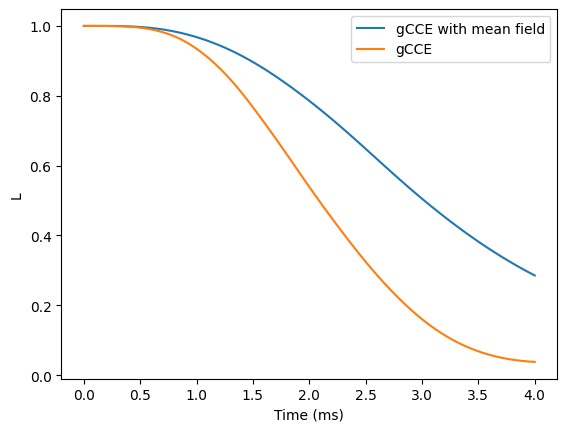

In [49]:
import mpi4py

helgcce = calc.compute(time_space, nbstates=30, seed=seed,
                       method='gcce', quantity='coherence',
                       parallel=True)

plt.plot(ts, helgcce, label='gCCE with mean field')
plt.plot(ts, helgen, label='gCCE')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('L');